In [19]:
# Codes from pythorch tutorial
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
# 1. download CIFAR10 and normalize it [0, 1] to [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


0it [00:00, ?it/s]


100%|█████████▉| 169787392/170498071 [00:24<00:00, 7359042.40it/s]

Files already downloaded and verified


  cat   car   cat truck


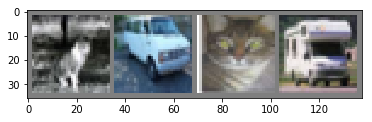

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# select random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show image
imshow(torchvision.utils.make_grid(images))
# print answer(label)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
# 2. define cnn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # overrided
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [22]:
# 3. define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
# 4. train
for epoch in range(2):  # iterate dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get input
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        # we need to set all variables 0 before back propagation step
        # because, by default, gradients are accumulated not be rewritten
        # see torch.autograd.backward() documentation
        optimizer.zero_grad()

        # forward propagation:
        # nn.Module.__call__() will be called by'net(inputs)'
        # and Net.forward() will be called inside 'nn.Module.__call__()'
        outputs = net(inputs)
        
        # get loss
        loss = criterion(outputs, labels)
        
        # back propagation:
        # if requires_grad = True, 'loss' has parameters(weights) of nn.Module
        # therefore, loss.bakcward() works fine
        loss.backward()
        
        # update all weights
        optimizer.step()

        # print statistics
        running_loss += loss.data
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.231
[1,  4000] loss: 1.879
[1,  6000] loss: 1.689
[1,  8000] loss: 1.594
[1, 10000] loss: 1.491
[1, 12000] loss: 1.447
[2,  2000] loss: 1.403
[2,  4000] loss: 1.342
[2,  6000] loss: 1.321
[2,  8000] loss: 1.307
[2, 10000] loss: 1.263
[2, 12000] loss: 1.269
Finished Training


GroundTruth:    cat  ship  ship plane


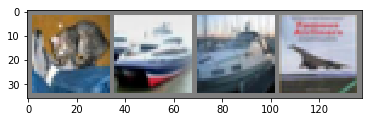

In [27]:
# 5. test with test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# show groundtruth
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
# predict given images
outputs = net(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [29]:
# pridict all test data
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [48]:
# evaluate accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * float(class_correct[i]) / class_total[i]))

Accuracy of plane :  1 %
Accuracy of   car : 13 %
Accuracy of  bird : 21 %
Accuracy of   cat :  4 %
Accuracy of  deer : 23 %
Accuracy of   dog : 11 %
Accuracy of  frog : 21 %
Accuracy of horse :  5 %
Accuracy of  ship :  9 %
Accuracy of truck :  6 %
